## Load data

In [1]:
%matplotlib inline
import os
os.chdir("/user/hl3541/RL_Expedia/Expedia")

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def load_clickstream(path, sep=","):
    cols = [
        "SITE_NAME", "GMT_DTM", "IP_ADDRESS", "GEO_SEGMENT_LOCATION", "VISITOR_ID_HIGH", 
        "VISITOR_ID_LOW", "GUID", "VISIT_NUMBER", "OMNITURE_MARKET_CLICKS_PAGE", "URL", "REFERRING_URL",
        "SEARCH_ENGINE_NAME", "SEARCH_KEYWORDS", "EVENT_LIST_IDS", "ALL_MARKETING_CODE", "EMAIL", "SEM", 
        "LOCAL_DTM", "SEARCH_ENGINE_PAGE_NUMBER", "PAGE_NUMBER", "LOB_SHOPPER", "ALL_MARKETING_CODE_WITHOUT_SEO",
        "ENTRY_PAGE_NAME", "ENTRY_PAGE_REFERRING_URL", "ENTRY_PAGE_URL", "PREVIOUS_PURCHASE_GMT_TIME", 
        "SEARCH_LOB", "SEARCH_ORIGIN", "SEARCH_DESTINATION", "SEARCH_WINDOW", "SEARCH_DURATION", "DRR",
        "INT_CAMPAIGN_DIRECT", "RFRR_ID", "ABACUS_TEST_ID", "UNIQUE_LEAD_ID", "TUID", "BROWSER_TYPE", 
        "OPERATING_SYSTEM", "NON_PERSISTANT_ALLMKT_SEO", "PROPERTY_ID"
    ]

    data = pd.read_csv(path, sep=sep, header=None,)
    data.columns = cols
    return data

def load_searchtrans(path, sep=","):
    cols = [
        "wcai_market", "LODG_SRCH_REQST_KEY", "GUID", "SRCH_DATETM", "TUID", "TRVL_PRODUCT_ID", "PARTNR_ID", "SRCH_BEGIN_USE_DATE",
        "SRCH_END_USE_DATE", "SRCH_RM_CNT", "SRCH_ADULT_CNT", "SRCH_CHILD_CNT", "RESOLVED_DEST_REGN_ID", "SRCH_MIN_STAR_RTG", 
        "TOTL_RESULTS_CNT", "SRCH_DEST_TXT", "SRCH_LODG_PROPERTY_NAME", "SRT_TYP_ID", "LODG_RESP_PAGE_DESC", "TRL", "CLICK_THRU_DATETM", "CLICK_THRU_TYP_ID",
        "RESP_LODG_PROPERTY_ID", "RESP_PAGE_POSITION_VALUE", "RESP_BUSINESS_MODEL_ID", "LODG_PROPERTY_AVAIL_STATE_ID", "RESP_STAR_RTG_VALUE","TRVLR_REVIEW_AVG_RTG",
        "TRVLR_REVIEW_CNT", "LOWST_AVG_PRICE_AMT", "IS_PROMO_FLAG", "REGIONID", "REGIONSEMANTICDESC", "REGIONTYPEID", "MARKETID", "MARKETNAME","PSG_REGION",
        "PSG_SUPERREGION", "Hotel_Name", "Structure_Type_ID", "Room_Capacity", "Center_Latitude", "Center_Longitude", "Primary_Booking_Source", "Sub_Market_Name", "Brand_Name", 
        "Parent_Chain_Name", "City", "State", "Country", "ARI_Enabled_Bool", "Airport_Code", "Merchant_Bool"
    ]
    data = pd.read_csv(path, sep=sep, header=None,)
    data.columns = cols
    return data

# cs = load_clickstream("./Clickstream/clickstream.csv",)
st = load_searchtrans("./Search_Trans/search_trans.csv",)


/tmp/ipykernel_8310/274188676.py:42: DtypeWarning: Columns (4,5,6,9,10,11,12,13,14,17,18,19,21,22,23,24,25,26,31,33,34,39,40,41,42,43,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  st = load_searchtrans("./Search_Trans/search_trans.csv",)


## Feature selection

In [2]:
def select_feat_st(st):
    ## initial selection
    data = st[["TRVL_PRODUCT_ID", "SRCH_RM_CNT", "SRCH_ADULT_CNT", "SRCH_MIN_STAR_RTG", "TOTL_RESULTS_CNT",
               "SRT_TYP_ID","RESP_PAGE_POSITION_VALUE", "LODG_RESP_PAGE_DESC", "REGIONTYPEID", "Room_Capacity", 
               "RESP_STAR_RTG_VALUE", "TRVLR_REVIEW_AVG_RTG", "TRVLR_REVIEW_CNT", 
            ]].copy()

    ## Preprocess
    ## is promoted
    data["IS_PROMO_FLAG"] = st["IS_PROMO_FLAG"].map({"Y":1, "N":0})

    ## available
    data["LODG_PROPERTY_AVAIL_STATE_ID"] = st["LODG_PROPERTY_AVAIL_STATE_ID"].apply(lambda x: int(x) if x in ("4","2","1") else x)

    ## price 
    data["LOWST_AVG_PRICE_AMT"] = st["LOWST_AVG_PRICE_AMT"]

    ## Purchase
    data["purchase"] = st["CLICK_THRU_TYP_ID"].apply(lambda x: 1 if x=="3406" or x==3406 else 0)

    ## Viewed detail
    data["viewed_detail"] = st["CLICK_THRU_TYP_ID"].apply(lambda x: 1 if x=="3402" or x==3402 else 0)

    ## Viewed price
    data["viewed_price"] = st["CLICK_THRU_TYP_ID"].apply(lambda x: 1 if x=="3404" or x==3404 else 0)

    ## drop if price is nan
    data.replace({r"\N": np.nan}, inplace=True)
    data.dropna(subset=["LOWST_AVG_PRICE_AMT"], inplace=True)
    data = data.astype(float)

    return data

data = select_feat_st(st)
data


,TRVL_PRODUCT_ID,SRCH_RM_CNT,SRCH_ADULT_CNT,SRCH_MIN_STAR_RTG,TOTL_RESULTS_CNT,SRT_TYP_ID,RESP_PAGE_POSITION_VALUE,LODG_RESP_PAGE_DESC,REGIONTYPEID,Room_Capacity,RESP_STAR_RTG_VALUE,TRVLR_REVIEW_AVG_RTG,TRVLR_REVIEW_CNT,IS_PROMO_FLAG,LODG_PROPERTY_AVAIL_STATE_ID,LOWST_AVG_PRICE_AMT,purchase,viewed_detail,viewed_price
0,1.0,1.0,1.0,0.0,267.0,0.0,11.0,1.0,11.0,424.0,40.0,4.0,10.0,1.0,1.0,72.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,267.0,0.0,14.0,1.0,11.0,322.0,50.0,4.8,25.0,0.0,1.0,161.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,267.0,0.0,21.0,1.0,11.0,262.0,40.0,4.2,5.0,1.0,1.0,59.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,267.0,0.0,17.0,1.0,11.0,234.0,40.0,3.6,10.0,0.0,1.0,81.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,267.0,0.0,13.0,1.0,11.0,366.0,50.0,4.6,20.0,1.0,1.0,126.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1546290,25.0,2.0,2.0,0.0,1444.0,0.0,18.0,1.0,11.0,134.0,40.0,4.2,10.0,0.0,1.0,355.0,0.0,0.0,0.0
1546291,25.0,2.0,2.0,0.0,1444.0,0.0,8.0,1.0,11.0,289.0,40.0,4.5,30.0,1.0,1.0,171.0,0.0,0.0,0.0
1546292,25.0,2.0,2.0,0.0,1444.0,0.0,5.0,1.0,11.0,99.0,40.0,4.3,5.0,1.0,1.0,421.0,0.0,0.0,0.0
1546293,25.0,2.0,2.0,0.0,1444.0,0.0,7.0,1.0,11.0,NaN,40.0,NaN,NaN,1.0,1.0,286.0,0.0,0.0,0.0


## Data Analysis

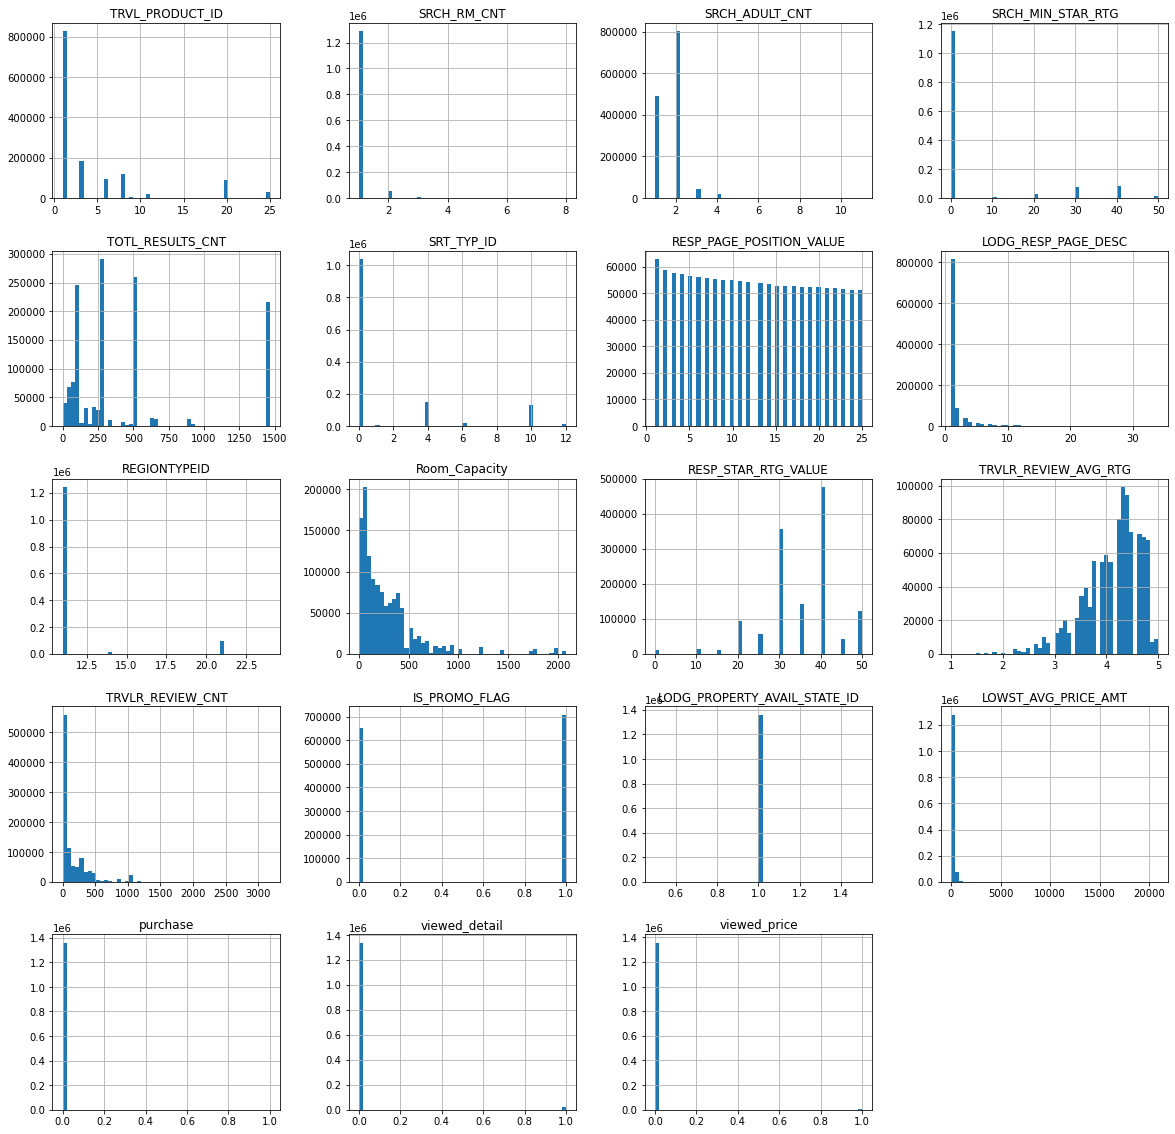

In [3]:
_ = data.hist(bins=50, figsize=(20,20))

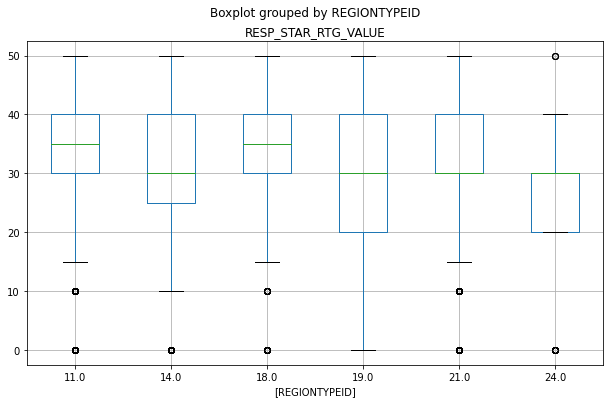

In [4]:
_ = data[["RESP_STAR_RTG_VALUE","REGIONTYPEID"]].boxplot(by="REGIONTYPEID",figsize=(10,6))

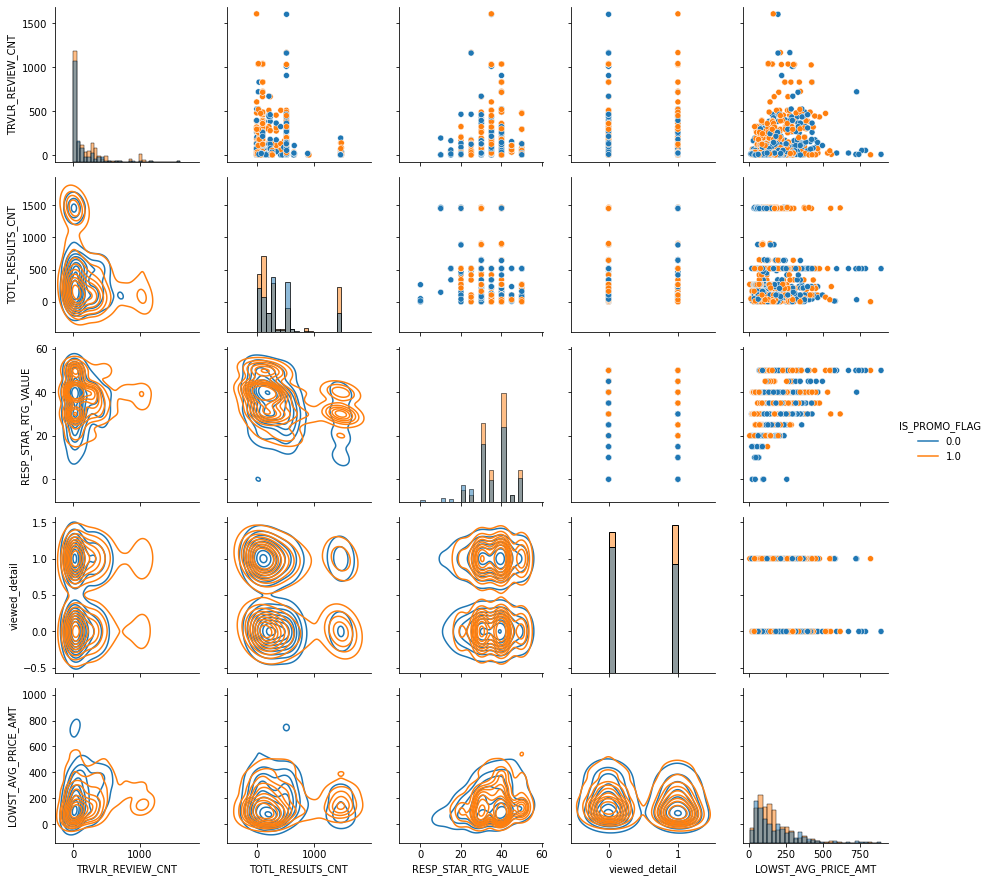

In [5]:
np.random.seed(42)
t = data[['TRVLR_REVIEW_CNT', 'TOTL_RESULTS_CNT', 'RESP_STAR_RTG_VALUE', 'IS_PROMO_FLAG', 'viewed_detail', "LOWST_AVG_PRICE_AMT"]].copy()
n = len(data[data["viewed_detail"]==1])
t = pd.concat([t[t["viewed_detail"]==1], t[t["viewed_detail"]==0].sample(n)], axis=0).sample(1000)
g = sns.PairGrid(t, hue="IS_PROMO_FLAG")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

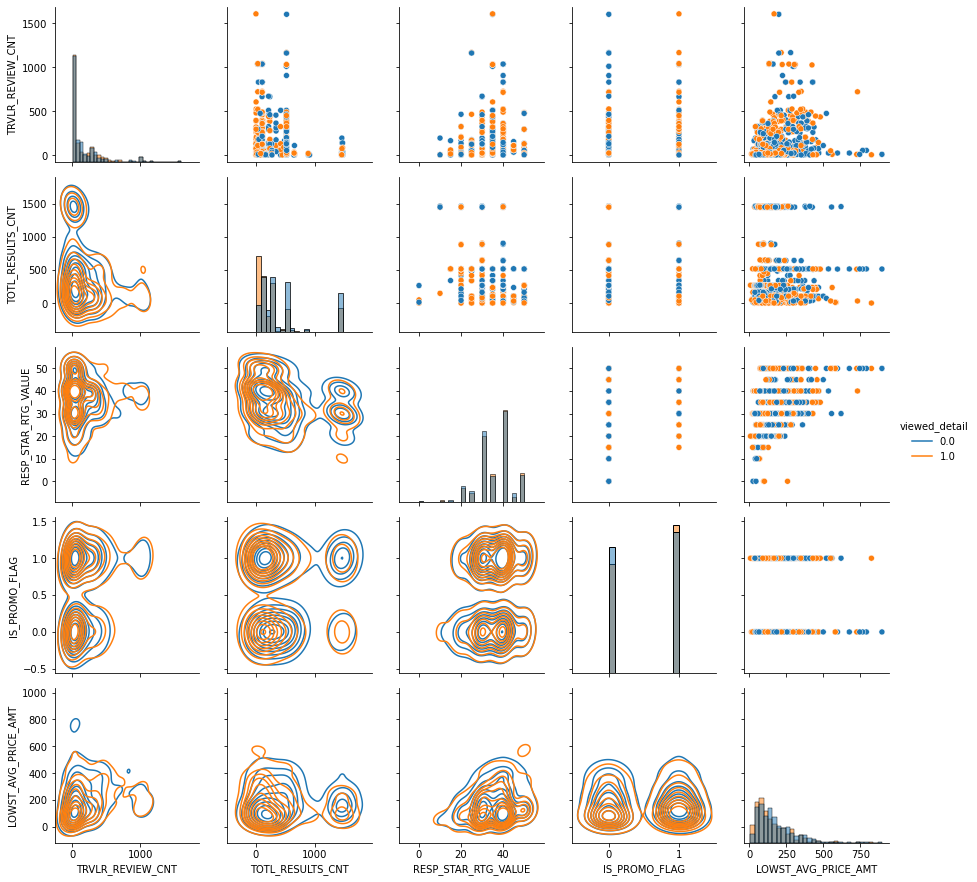

In [6]:
g = sns.PairGrid(t, hue="viewed_detail")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

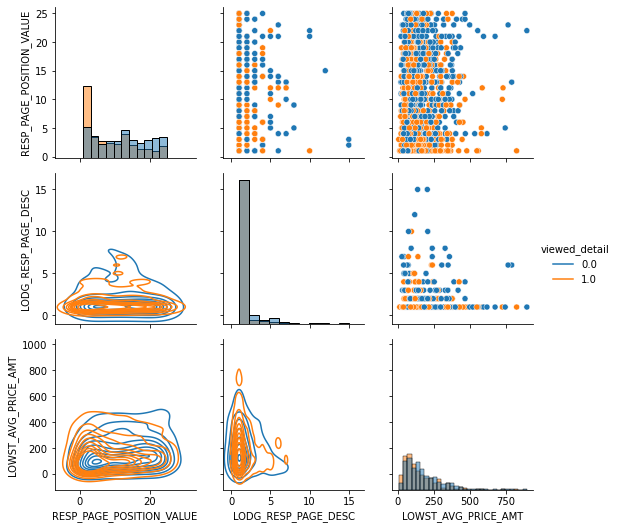

In [7]:
np.random.seed(42)
t = data[['RESP_PAGE_POSITION_VALUE', 'LODG_RESP_PAGE_DESC', 'viewed_detail', "LOWST_AVG_PRICE_AMT"]].copy()
n = len(data[data["viewed_detail"]==1])
t = pd.concat([t[t["viewed_detail"]==1], t[t["viewed_detail"]==0].sample(n)], axis=0).sample(1000)
g = sns.PairGrid(t, hue="viewed_detail")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

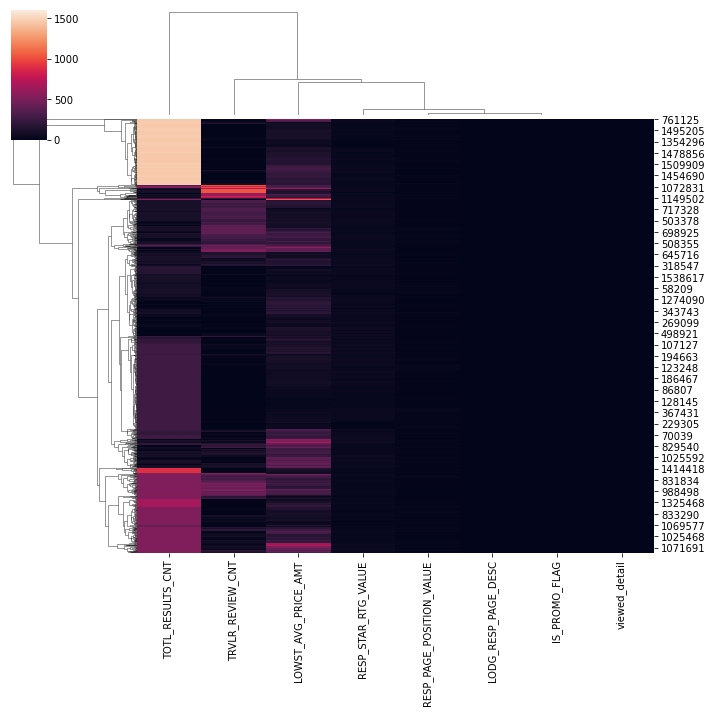

In [38]:
t = data[['RESP_PAGE_POSITION_VALUE', 'LODG_RESP_PAGE_DESC','TRVLR_REVIEW_CNT', 'TOTL_RESULTS_CNT', 'RESP_STAR_RTG_VALUE', 'IS_PROMO_FLAG', 'viewed_detail', "LOWST_AVG_PRICE_AMT"]].copy()
n = len(data[data["viewed_detail"]==1])
t = pd.concat([t[t["viewed_detail"]==1], t[t["viewed_detail"]==0].sample(n)], axis=0).sample(1000)
sns.clustermap(t.fillna(0))

## Feature Engineering

In [8]:
## categorical: onehot
def create_onehot(x, feats):
    res, data = [], x.copy()
    for feat in feats:
        res.append(pd.get_dummies(data[feat],prefix=feat, drop_first=True))
        data.pop(feat)
    
    return pd.concat([data] + res, axis=1)

## continuous: normalization
# zscore -> Gaussian
def zscore(x, lognorm=False, EPS=1e-8):
    # robust zscore
    if lognorm:
        x = np.log(x)
    x = x - x.median()  # copy
    x /= np.abs(x).median() * 1.4826 + EPS
    x.clip(-3, 3, inplace=True)
    x -= x.mean()
    x /= x.std(ddof=0) + EPS
    return x
        
# rank -> Uniform
def rank(x):
    x = x.rank(pct=True) 
    x = (x - 0.5) * np.sqrt(12)
    return x

def preprosess(data):
    # Cat: "TRVL_PRODUCT_ID", "SRT_TYP_ID", "REGIONTYPEID", "LODG_PROPERTY_AVAIL_STATE_ID", "IS_PROMO_FLAG"(encoded)
    # Lognorm: "Room_Capacity","TRVLR_REVIEW_CNT","LOWST_AVG_PRICE_AMT"
    # Norm: "TRVLR_REVIEW_AVG_RTG"
    # Uniform: "SRCH_RM_CNT","SRCH_ADULT_CNT","SRCH_MIN_STAR_RTG","TOTL_RESULTS_CNT","RESP_PAGE_POSITION_VALUE","LODG_RESP_PAGE_DESC","RESP_STAR_RTG_VALUE"
    feat = ["TRVL_PRODUCT_ID", "SRT_TYP_ID", "REGIONTYPEID", "LODG_PROPERTY_AVAIL_STATE_ID"]
    res = create_onehot(data, feat)
    feat = ["Room_Capacity","TRVLR_REVIEW_CNT","LOWST_AVG_PRICE_AMT"]
    res.loc[:, feat] = res[feat].apply(zscore, lognorm=True)
    feat = ["TRVLR_REVIEW_AVG_RTG"]
    res.loc[:, feat] = res[feat].apply(zscore, lognorm=False)
    feat = ["SRCH_RM_CNT","SRCH_ADULT_CNT","SRCH_MIN_STAR_RTG","TOTL_RESULTS_CNT","RESP_PAGE_POSITION_VALUE","LODG_RESP_PAGE_DESC","RESP_STAR_RTG_VALUE"]
    res.loc[:, feat] = res[feat].apply(rank)
    
    # move labels
    res["viewed_detail"] = res.pop("viewed_detail")
    res["viewed_price"] = res.pop("viewed_price")
    res["purchase"] = res.pop("purchase")
    
    # fillna
    res.fillna(0, inplace=True)
    
    return res

data = preprosess(data)

/apps/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
data.to_pickle("./Search_Trans/search_trans_selected.pkl")

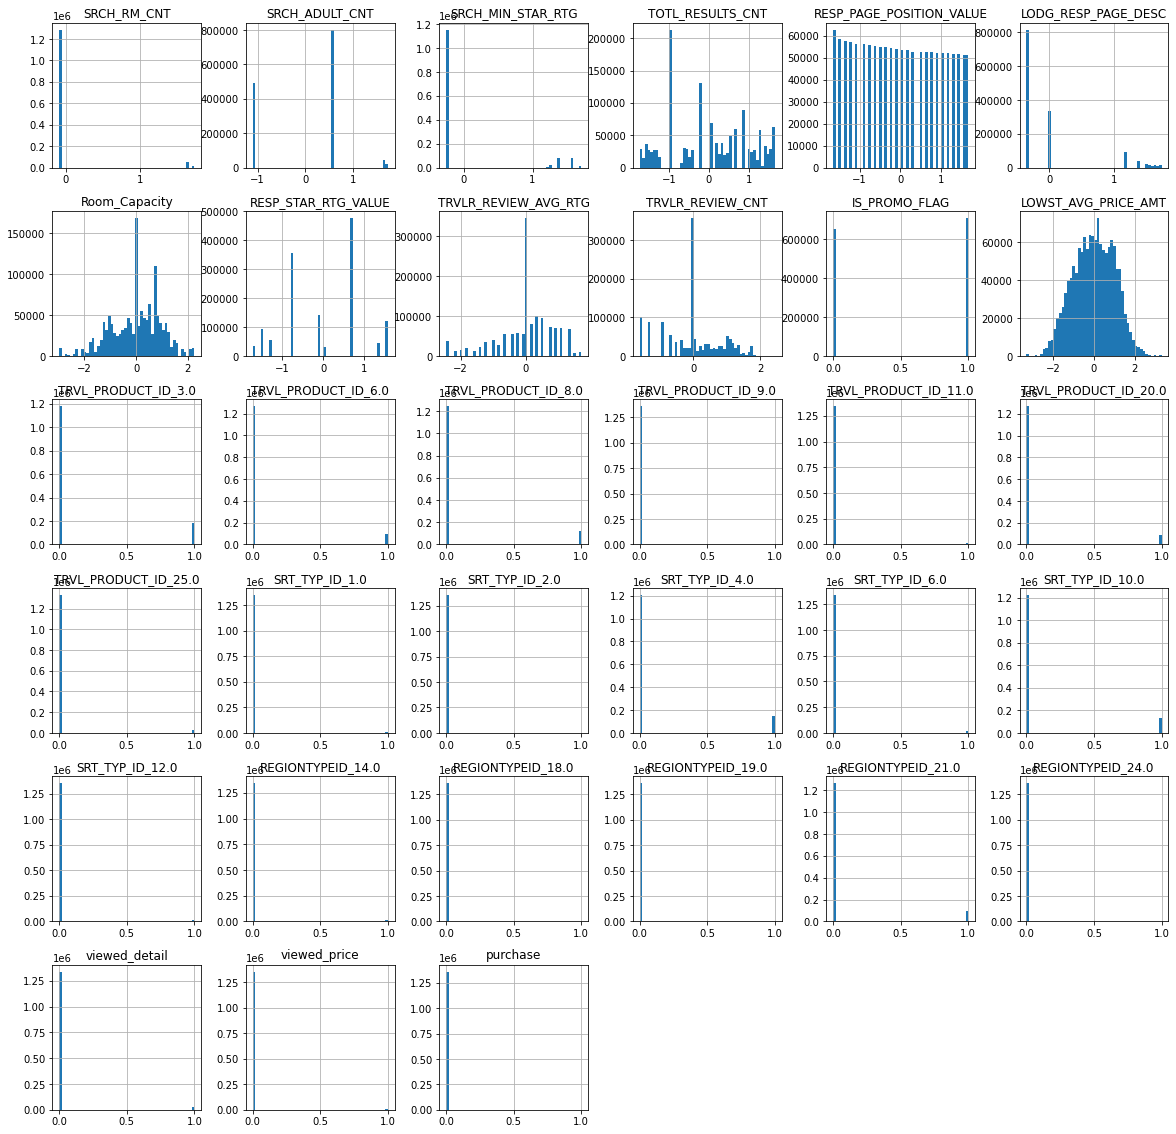

In [22]:
_ = data.hist(bins=50, figsize=(20,20))

## In-out sample split

In [5]:
def split_ds(df, split_ratio=[0.8, 0.1]):
    
    np.random.seed(42)
    df = df.sample(frac=1)
    n = len(df)
    n_tr = int(n * split_ratio[0])
    n_va = int(n * split_ratio[1])
    
    train = df.values[: n_tr]
    valid = df.values[n_tr : n_tr + n_va]
    test = df.values[n_tr + n_va: ]
    
    return train, valid, test
    
train, valid, test = split_ds(data)

## Bayesian Logistic

Valid 0: 100%|██████████| 531/531 [00:00<00:00, 1173.44it/s]


Log likilihood on validation: -56.266555840012714


Valid 1: 100%|██████████| 531/531 [00:00<00:00, 1176.36it/s]


Log likilihood on validation: -52.89166349924666


Valid 2: 100%|██████████| 531/531 [00:00<00:00, 1174.25it/s]


Log likilihood on validation: -51.596619090566975


Valid 3: 100%|██████████| 531/531 [00:00<00:00, 1175.70it/s]


Log likilihood on validation: -50.85672182776385


Valid 4: 100%|██████████| 531/531 [00:00<00:00, 1176.45it/s]


Log likilihood on validation: -50.36619355225069


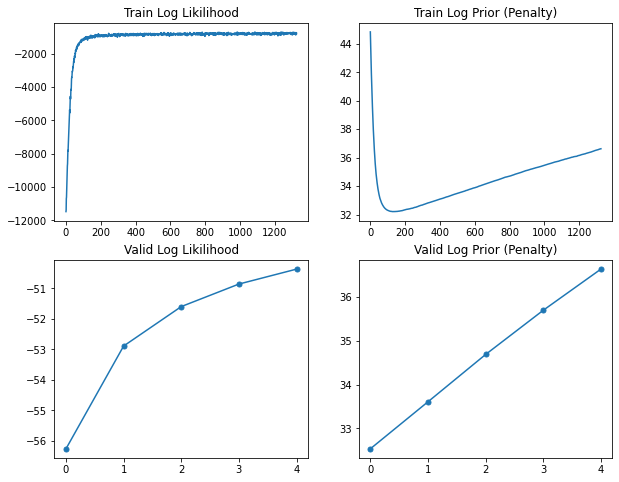

In [28]:
import torch
import torch.nn as nn
import copy

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

## hyper parameters
args = dict(
    batchsize = 4096,
    lamb = 0.5,
    n_epochs = 5,
    lr = 1e-4,
    verbose=True,
)


def train_epoch(epoch, loader, model, opt, eval_dict, args):
    
    lamb = args["lamb"]
    for batch in tqdm(loader, desc=f"Train {epoch}", disable=not args["verbose"]):
        X, y = batch[:, :-3].float(), batch[:, -3].long()
        logits = X @ model
        reg = 0.5 * lamb * (model**2).sum()
        LL = torch.sum(y * logits.sigmoid().log() + (1-y) * (-logits).sigmoid().log())
        (- reg - LL).backward()
        opt.step()
        opt.zero_grad()
        eval_dict["LL"].append(LL.item())
        eval_dict["penalty"].append(reg.item())
    return eval_dict
    
def eval_epoch(epoch, loader, model, prefix="Valid", args=None):
    lamb = args["lamb"]
    res = {"LL":[], "penalty":[]}
    for batch in tqdm(loader, desc=f"{prefix} {epoch}", disable=not args["verbose"]):
        X, y = batch[:, :-3].float(), batch[:, -3].long()
        logits = X @ model
        reg = 0.5 * lamb * (model**2).sum()
        LL = torch.sum(y * logits.sigmoid().log() + (1-y) * (-logits).sigmoid().log())
        res["LL"].append(LL.item())
        res["penalty"].append(reg.item())
    return res
    
def main(data, args):
    ## hyper params
    batchsize = args["batchsize"]
    n_epochs = args["n_epochs"]
    lamb = args["lamb"]
    lr = args["lr"]
    n_feat = data.shape[1] - 3
    
    ## data
    train_loader = torch.utils.data.DataLoader(train, batch_size=batchsize, shuffle=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=256, drop_last=True)

    ## model and optimizer
    beta = nn.Parameter(torch.normal(mean=torch.zeros(n_feat), std=torch.ones(n_feat)/lamb))
    opt = torch.optim.SGD([beta], lr=lr)

    ## records
    train_ll = {"LL":[], "penalty":[]}
    valid_ll = {"LL":[], "penalty":[]}
    best = {"LL": -np.inf, "epoch":0, "model":[beta]}
    for epoch in range(n_epochs):
        train_epoch(epoch, train_loader, beta, opt, train_ll, args)
        res = eval_epoch(epoch, valid_loader, beta, "Valid", args)
        valid_ll["LL"].append(np.mean(res["LL"]))
        valid_ll["penalty"].append(np.mean(res["penalty"]))
        LL = np.mean(res["LL"]) # + np.mean(res["penalty"])
        if args["verbose"]:
            print(f"Log likilihood on validation: {LL}")
        if LL > best["LL"]:
            best["LL"] = np.mean(res["LL"]) + np.mean(res["penalty"])
            best["epoch"] = epoch
            best["model"] = copy.deepcopy(beta)

    ## plot
    train_ll = pd.DataFrame(train_ll)
    valid_ll = pd.DataFrame(valid_ll)
    if args["verbose"]:
        fig, axes = plt.subplots(2,2, figsize=(10,8))
        axes = axes.flatten()
        _ = train_ll.LL.plot(title="Train Log Likilihood", ax=axes[0])
        _ = train_ll.penalty.plot(title="Train Log Prior (Penalty)", ax=axes[1])

        _ = valid_ll.LL.plot(title="Valid Log Likilihood", ax=axes[2], ms=5, style="-o")
        _ = valid_ll.penalty.plot(title="Valid Log Prior (Penalty)", ax=axes[3], ms=5, style="-o")

    return valid_ll, best

t, best = main(data, args)

## Coefficients

In [29]:
res = pd.DataFrame(best["model"].detach().numpy(), index=data.columns[:-3], columns=["coef"])
print(res.to_latex())

\begin{tabular}{lr}
\toprule
{} &      coef \\
\midrule
SRCH\_RM\_CNT              &  1.167142 \\
SRCH\_ADULT\_CNT           & -0.026331 \\
SRCH\_MIN\_STAR\_RTG        &  0.279388 \\
TOTL\_RESULTS\_CNT         &  0.145840 \\
RESP\_PAGE\_POSITION\_VALUE & -0.328955 \\
LODG\_RESP\_PAGE\_DESC      & -0.117146 \\
Room\_Capacity            & -0.030231 \\
RESP\_STAR\_RTG\_VALUE      &  0.202469 \\
TRVLR\_REVIEW\_AVG\_RTG     & -0.141273 \\
TRVLR\_REVIEW\_CNT         & -0.115919 \\
IS\_PROMO\_FLAG            & -3.947947 \\
LOWST\_AVG\_PRICE\_AMT      & -0.548281 \\
TRVL\_PRODUCT\_ID\_3.0      & -2.722067 \\
TRVL\_PRODUCT\_ID\_6.0      & -2.062712 \\
TRVL\_PRODUCT\_ID\_8.0      & -4.806024 \\
TRVL\_PRODUCT\_ID\_9.0      & -0.488276 \\
TRVL\_PRODUCT\_ID\_11.0     & -2.931265 \\
TRVL\_PRODUCT\_ID\_20.0     & -2.355393 \\
TRVL\_PRODUCT\_ID\_25.0     & -0.757699 \\
SRT\_TYP\_ID\_1.0           &  3.155360 \\
SRT\_TYP\_ID\_2.0           &  0.597196 \\
SRT\_TYP\_ID\_4.0           & -1.418002 \\
SRT\_

## change prior

100%|██████████| 4/4 [01:25<00:00, 21.29s/it]


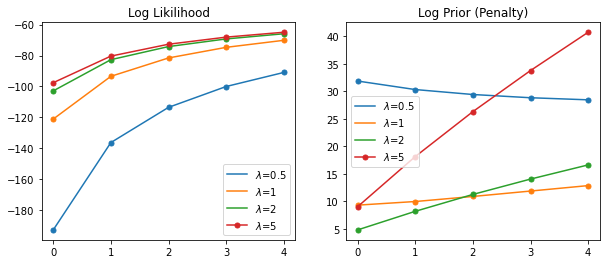

In [42]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
for prior in tqdm([0.5, 1, 2, 5]):
    
    args = dict(
        batchsize = 4096,
        lamb = prior,
        n_epochs = 5,
        lr = 1e-5,
        verbose=False,
    )
    t, _  = main(data, args)
    LL, penalty = t.LL, t.penalty
    LL.name = f"$\lambda$={prior}"
    penalty.name = f"$\lambda$={prior}"
    LL.plot(title=f"Log Likilihood", ax=axes[0], ms=5, style="-o", legend=True)
    penalty.plot(title="Log Prior (Penalty)", ax=axes[1], ms=5, style="-o", legend=True)


## change batchsize

100%|██████████| 3/3 [01:12<00:00, 24.02s/it]


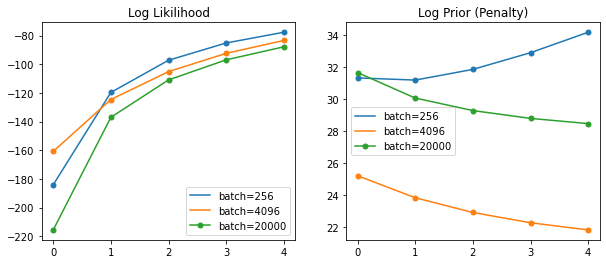

In [43]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
for bs in tqdm([256, 4096, 20000]):
    
    args = dict(
        batchsize = bs,
        lamb = 0.5,
        n_epochs = 5,
        lr = 1e-5,
        verbose=False,
    )
    t, _ = main(data, args)
    LL, penalty = t.LL, t.penalty
    LL.name = f"batch={bs}"
    penalty.name = f"batch={bs}"
    LL.plot(title=f"Log Likilihood", ax=axes[0], ms=5, style="-o", legend=True)
    penalty.plot(title="Log Prior (Penalty)", ax=axes[1], ms=5, style="-o", legend=True)


## change learning rate

100%|██████████| 3/3 [01:02<00:00, 20.96s/it]


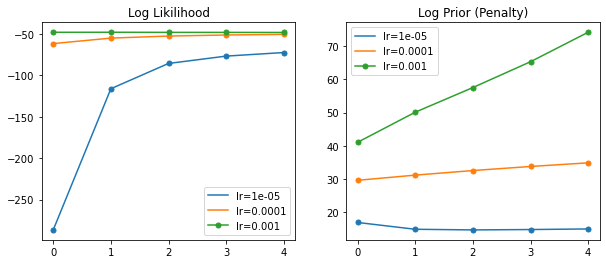

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
for lr in tqdm([1e-5, 1e-4, 1e-3]):
    
    args = dict(
        batchsize = 4096,
        lamb = 0.5,
        n_epochs = 5,
        lr = lr,
        verbose=False,
    )
    t, _ = main(data, args)
    LL, penalty = t.LL, t.penalty
    LL.name = f"lr={lr}"
    penalty.name = f"lr={lr}"
    LL.plot(title=f"Log Likilihood", ax=axes[0], ms=5, style="-o", legend=True)
    penalty.plot(title="Log Prior (Penalty)", ax=axes[1], ms=5, style="-o", legend=True)


## evaluation on test dataset

In [7]:
X = torch.tensor(test[:,:-3], dtype=torch.float)
y = torch.tensor(test[:,-3], dtype=torch.long)
logits = X @ best["model"]
pred = logits.sigmoid().gt(0.5).long()

              precision    recall  f1-score   support

           0      0.984     0.881     0.930    133729
           1      0.020     0.145     0.035      2231

    accuracy                          0.869    135960
   macro avg      0.502     0.513     0.483    135960
weighted avg      0.968     0.869     0.915    135960



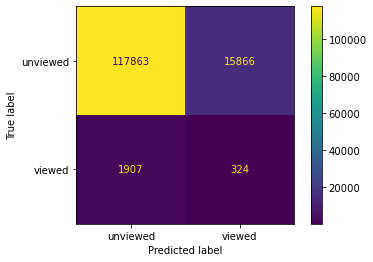

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

m = confusion_matrix(y.numpy(), pred.numpy())
_ = ConfusionMatrixDisplay(m, display_labels=["unviewed","viewed"]).plot()
print(classification_report(y.numpy(), pred.numpy(), labels=[0, 1], digits=3))